## Movie Data Analysis

Please fill out:
* Student name: Yue Yu, Margaret Boland, Peter Burton 
* Student pace: full time
* Scheduled project review date/time: June 3rd 2022
* Instructor name: 
* Blog post URL:


In [1]:
import pandas as pd
import numpy as np
import sqlite3
import zipfile
import matplotlib.pyplot as plt

In [2]:
# upzip im.db.zip file
with zipfile.ZipFile('./zippedData/im.db.zip') as zipObj:
    zipObj.extractall(path='./zippedData/')

In [3]:
con = sqlite3.connect('zippedData/im.db')
cursor = con.cursor()

In [4]:
# check table names
schema_df = pd.read_sql("""
                        SELECT 
                            *
                        FROM 
                            sqlite_master """, con)
schema_df

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


We think genres, director and runtime of the movie have large impact on the profitability of a movie. So, we are going to make a table that contains all these information first.

## Make a clean budget table

In [5]:
df_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
df_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [6]:
"""All the numbers in this table need to be converted to integers"""

df_budgets['budgets(USD)'] = df_budgets['production_budget'].str.replace('$','').str.replace(',', '').astype(int)
df_budgets['dom_gross(USD)'] = df_budgets['domestic_gross'].str.replace('$','').str.replace(',', '').astype(int)
df_budgets['world_gross(USD)'] = df_budgets['worldwide_gross'].str.replace('$','').str.replace(',', '').astype('int64')

In [7]:
# keep the int columns only
budget_clean = df_budgets.drop(['production_budget','domestic_gross','worldwide_gross'], axis=1)
budget_clean.head()

,id,release_date,movie,budgets(USD),dom_gross(USD),world_gross(USD)
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747


We are going to work with data from the SQL database. The next step is to put together all the data we need from the database with the budget table above.

## Join movie_basics and budget_clean

In [8]:
df_basics = pd.read_sql("""
                        SELECT 
                            movie_id, 
                            primary_title AS movie, 
                            genres, 
                            runtime_minutes
                        FROM 
                            movie_basics """, con)

In [9]:
# we want all the movies' name and movie id to be shown in the table.
movie_budget = budget_clean.merge(df_basics, on='movie')
df_budget_merged = movie_budget
movie_budget.head()


,id,release_date,movie,budgets(USD),dom_gross(USD),world_gross(USD),movie_id,genres,runtime_minutes
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,tt1775309,Horror,93.0
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,tt1298650,"Action,Adventure,Fantasy",136.0
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,tt6565702,"Action,Adventure,Sci-Fi",113.0
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,tt2395427,"Action,Adventure,Sci-Fi",141.0
4,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,tt4154756,"Action,Adventure,Sci-Fi",149.0


## Calculate profit of each movie

In [10]:
# add a new column that shows the profit of each movie
movie_budget['Estimated Profit'] = movie_budget['world_gross(USD)']-movie_budget['budgets(USD)']
movie_budget.head()

,id,release_date,movie,budgets(USD),dom_gross(USD),world_gross(USD),movie_id,genres,runtime_minutes,Estimated Profit
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,tt1775309,Horror,93.0,2351345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,tt1298650,"Action,Adventure,Fantasy",136.0,635063875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,tt6565702,"Action,Adventure,Sci-Fi",113.0,-200237650
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,tt2395427,"Action,Adventure,Sci-Fi",141.0,1072413963
4,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,tt4154756,"Action,Adventure,Sci-Fi",149.0,1748134200


## Make the final table include all the data we need

In [11]:
df_directors = pd.read_sql("""
                        SELECT 
                            *
                        FROM 
                            directors """, con)
df_directors.head()

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502


In [12]:
df_person = pd.read_sql("""
                        SELECT 
                            *
                        FROM 
                            persons """, con)
df_person.head()

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"


In [13]:
director_df = pd.read_sql("""
                            SELECT
                                d.movie_id, 
                                p.primary_name AS director_name
                            FROM 
                                directors AS d
                                INNER JOIN persons AS p
                                    ON d.person_id = p.person_id
                                """, con)
director_df.head()

,movie_id,director_name
0,tt0285252,Tony Vitale
1,tt0462036,Bill Haley
2,tt0835418,Jay Chandrasekhar
3,tt0835418,Jay Chandrasekhar
4,tt0878654,Albert Pyun


In [14]:
# add director names to the table
movie_df = movie_budget.merge(director_df, on='movie_id', how='inner')
movie_clean_df = movie_df.drop_duplicates(subset='movie',keep='first')
movie_clean_df.head()

,id,release_date,movie,budgets(USD),dom_gross(USD),world_gross(USD),movie_id,genres,runtime_minutes,Estimated Profit,director_name
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,tt1775309,Horror,93.0,2351345279,Atsushi Wada
2,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,tt1298650,"Action,Adventure,Fantasy",136.0,635063875,Rob Marshall
7,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,tt6565702,"Action,Adventure,Sci-Fi",113.0,-200237650,Simon Kinberg
13,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,tt2395427,"Action,Adventure,Sci-Fi",141.0,1072413963,Joss Whedon
18,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,tt4154756,"Action,Adventure,Sci-Fi",149.0,1748134200,Anthony Russo


## The most popular genres of top 100 profitable movies

In [15]:
most_profit_movie = movie_clean_df.sort_values(by=['Estimated Profit'],ascending=False)[:100]
most_profit_movie['genres'].value_counts().head(10)

Action,Adventure,Sci-Fi       25
Adventure,Animation,Comedy    15
Action,Adventure,Fantasy       8
Action,Adventure,Comedy        7
Action,Adventure,Animation     5
Adventure,Family,Fantasy       4
Action,Crime,Thriller          3
Adventure,Drama,Sci-Fi         2
Adventure,Fantasy              2
Animation,Comedy,Family        2
Name: genres, dtype: int64

In [16]:
most_profit_movie = movie_clean_df.sort_values(by=['Estimated Profit'],ascending=False)[:100]
profit_genres = movie_clean_df.sort_values(by=['Estimated Profit'], ascending=False)['genres'][:100]
pop_gen_ls = ['Act,Adv,Sci','Adv,Anim,Com','Act,Adv,Fan','Act,Adv,Com','Act,Adv,Anim','Adv,Fam,Fan','Act,Crim,Thri','Anim,Com, Fam',
             'Act,Adv,Thri','Adv,Dram,Sci']

In [1]:
fig, ax = plt.subplots(figsize=(15,8))
c = ['red','blue','blue','blue','blue','blue','blue','blue','blue','blue']
ax.bar(x=profit_genres.value_counts()[:10].index, height=profit_genres.value_counts()[:10], zorder=3,color=c)
ax.set_xlabel('Genres', fontsize=16)
ax.set_ylabel('Number Count')
plt.xticks(np.arange(0,10),fontsize=20,rotation=45,labels=pop_gen_ls,ha='right')
ax.set_title('Most Appeared Genres of Top 100 Profitable Movies', fontsize=16)
ax.grid(axis='y', zorder=0)
plt.show()
fig.savefig('most_appeared_genres.png',bbox_inches='tight');

NameError: name 'plt' is not defined

##  Average budget of each genre

In [56]:
genres = profit_genres.value_counts()[:10].index
top_profit_movie_genres = movie_clean_df.loc[movie_clean_df['genres'].isin(genres)]
profit_genres_ls = top_profit_movie_genres.groupby('genres')
mean_budgets = profit_genres_ls.mean()['budgets(USD)']

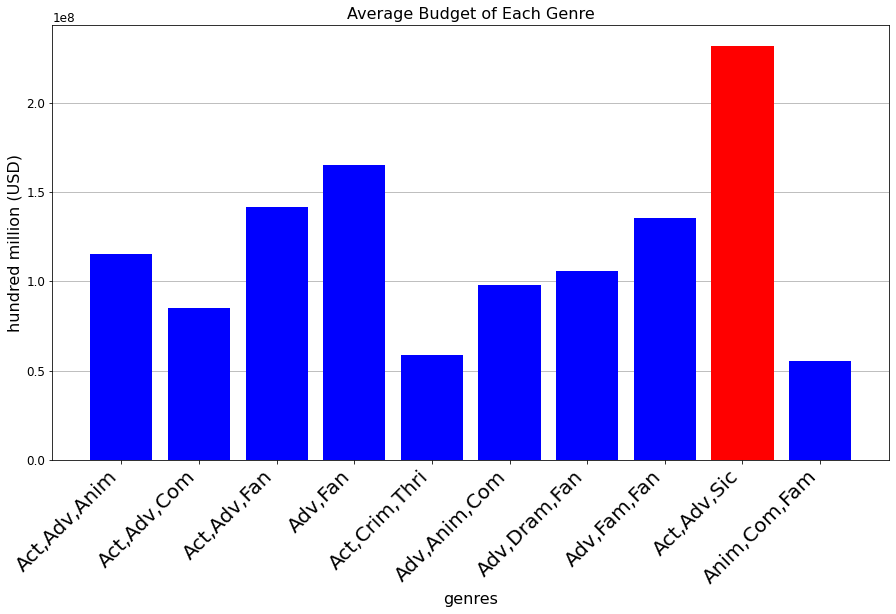

In [64]:
gen_ls = ['Act,Adv,Anim','Act,Adv,Com','Act,Adv,Fan','Adv,Fan','Act,Crim,Thri','Adv,Anim,Com',
         'Adv,Dram,Fan','Adv,Fam,Fan','Act,Adv,Sic','Anim,Com,Fam']
fig, ax = plt.subplots(figsize=(15,8))
c = ['blue','blue','blue','blue','blue','blue','blue','blue','red','blue']
ax.bar(x=mean_budgets.index, height=mean_budgets, zorder=3, color=c)
ax.set_xlabel('Genres', fontsize=16)
ax.set_ylabel('hundred million (USD)',fontsize=16)
plt.xticks(np.arange(0,10),fontsize=20,rotation=45,labels=gen_ls,ha='right')

ax.set_title('Average Budget of Each Genre', fontsize=16)
ax.grid(axis='y', zorder=0)
plt.show()
fig.savefig('Average_Budget.png',bbox_inches='tight');

## Adding Director Data to our Data Frame

## Cleaning New Updated Table

In [66]:
Top_500 = movie_clean_df.tail(500)
Top_100 = movie_clean_df.tail(100)
Top_250 = movie_clean_df.tail(250)
Top_50 = movie_clean_df.tail(50)

In [67]:
movie_clean_df.shape

(2298, 12)

In [68]:
Directors = (movie_clean_df['director_name'].unique())
Director_list = Directors.tolist()
Director_list


['Simon Kinberg',
 'Simon Wells',
 'F. Gary Gray',
 'David Ayer',
 'Chris Sanders',
 'Edwine Dorival',
 'Andrey Konchalovskiy',
 'Xiao Feng',
 'Chris Wedge',
 'Landen Wakil',
 'Richard Gilliam',
 'Frank Coraci',
 'Chris Jordan',
 'Nonzee Nimibutr',
 'Robert Schwentke',
 'Michael Mann',
 'Reed Morano',
 'James Gray',
 'Quentin Lee',
 'Emilio Roso',
 'Micah Fink',
 'Zakary Hallett',
 'Lawrence Kasanoff',
 'Neil Corbin',
 'Michael B. Clifford',
 'Ben Affleck',
 'Daniel Espinosa',
 'Nic Good',
 'Jess Carson',
 'John Crowley',
 'Alex Alessi',
 'Elizabeth Berry',
 'Emilio Rodriguez',
 'Mario Van Peebles',
 'Jimmy Hayward',
 'Ash Brannon',
 'Amanda Boyle',
 'Guy Ritchie',
 'Roland Joffé',
 'Mikael Håfström',
 'Werner Herzog',
 'Joel Schumacher',
 'Seok-hoon Lee',
 'Sngmoo Lee',
 'Peter Berg',
 'David Frankel',
 'Gabriele Muccino',
 'Robbie Pickering',
 'Jean-Pierre Jeunet',
 'Walter Hill',
 'Robert Zemeckis',
 'Matt Kendrick',
 'Joe Cornish',
 'Guel Arraes',
 'Andrew Tiernan',
 'Frédéric Aubu

## Creating a Dictionary of Directors with a list of their  profits in each of their films

In [69]:
directors_profits = dict(zip(movie_clean_df.director_name, movie_clean_df.estimated_profit))
directors_profits

{'Simon Kinberg': -200237650,
 'Simon Wells': -110450242,
 'F. Gary Gray': 984846267,
 'David Ayer': 571059887,
 'Chris Sanders': 438068425,
 'Edwine Dorival': -79448583,
 'Andrey Konchalovskiy': -69533984,
 'Xiao Feng': -64483721,
 'Chris Wedge': 162794441,
 'Landen Wakil': -61583254,
 'Richard Gilliam': -60376918,
 'Frank Coraci': 90805525,
 'Chris Jordan': -59500000,
 'Nonzee Nimibutr': -53296816,
 'Robert Schwentke': 30891409,
 'Michael Mann': -50334996,
 'Reed Morano': -50000000,
 'James Gray': -8414989,
 'Quentin Lee': -49318920,
 'Emilio Roso': -48884073,
 'Micah Fink': -48572910,
 'Zakary Hallett': -45183506,
 'Lawrence Kasanoff': -44926294,
 'Neil Corbin': -44373310,
 'Michael B. Clifford': -43467226,
 'Ben Affleck': 182640757,
 'Daniel Espinosa': 123542162,
 'Nic Good': -40515477,
 'Jess Carson': -40187130,
 'John Crowley': 51076141,
 'Alex Alessi': -39920877,
 'Elizabeth Berry': -39640994,
 'Emilio Rodriguez': -39536270,
 'Mario Van Peebles': -2270616,
 'Jimmy Hayward': 5538

In [70]:
sorted(directors_profits, key=directors_profits.get, reverse=True)

['Atsushi Wada',
 'Pete Meads',
 'Anthony Russo',
 'Colin Trevorrow',
 'James Wan',
 'Joss Whedon',
 'Ryan Coogler',
 'J.A. Bayona',
 'Adam Green',
 'Christophe Gans',
 'Pierre Coffin',
 'Brad Bird',
 'Shane Black',
 'F. Gary Gray',
 'Kyle Balda',
 'Ryan Fleck',
 'Michael Bay',
 'Sam Mendes',
 'Jon Favreau',
 'Jake Kasdan',
 'Jared Bush',
 'Lee Unkrich',
 'Gareth Edwards',
 'Bryan Singer',
 'Tim Burton',
 'Andrew Stanton',
 'Chris Renaud',
 'Christopher Nolan',
 'Jun Falkenstein',
 'Mike Thurmeier',
 'Peter Jackson',
 'Tim Miller',
 'Ruben Fleischer',
 'Francis Lawrence',
 'Jon Watts',
 'Artie Mandelberg',
 'David Leitch',
 'Patty Jenkins',
 'Taika Waititi',
 'Andy Muschietti',
 'David Slade',
 'Rob Marshall',
 'David Yates',
 'Zack Snyder',
 'Tom McGrath',
 'James Gunn',
 'Gary Ross',
 'Mike Mitchell',
 'Alfonso Cuarón',
 'Robert Stromberg',
 'David Ayer',
 'Christophe Lourdelet',
 'Joachim Rønning',
 'Ridley Scott',
 'Dan Scanlon',
 'Matt Reeves',
 'Marc Webb',
 'Sam Taylor-Johnson',

In [71]:
from operator import itemgetter
top_profits5 = dict(sorted(directors_profits.items(), key = itemgetter(1), reverse = True)[:5])
top_profits10 = dict(sorted(directors_profits.items(), key = itemgetter(1), reverse = True)[:10])

In [72]:
top_profits10

{'Atsushi Wada': 2351345279,
 'Pete Meads': 2008208395,
 'Anthony Russo': 1748134200,
 'Colin Trevorrow': 1433854864,
 'James Wan': 1328722794,
 'Joss Whedon': 1292935897,
 'Ryan Coogler': 1148258224,
 'J.A. Bayona': 1135772799,
 'Adam Green': 1122469910,
 'Christophe Gans': 1099199706}

## Graphing Top Directors by Individual Movie Profit 

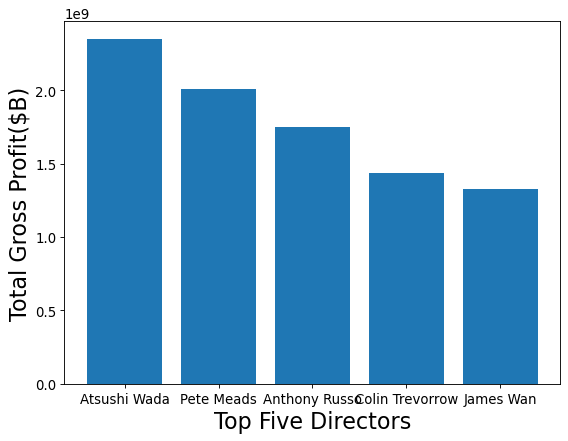

In [73]:
from matplotlib.pyplot import figure
keys = top_profits5.keys()
values = top_profits5.values()
figure(figsize=(8, 6), dpi=80)
plt.rcParams.update({'font.size': 12})
plt.bar(keys, values)
plt.xlabel('Top Five Directors', fontsize=20)
plt.ylabel('Total Gross Profit($B)', fontsize=20)
plt.show()



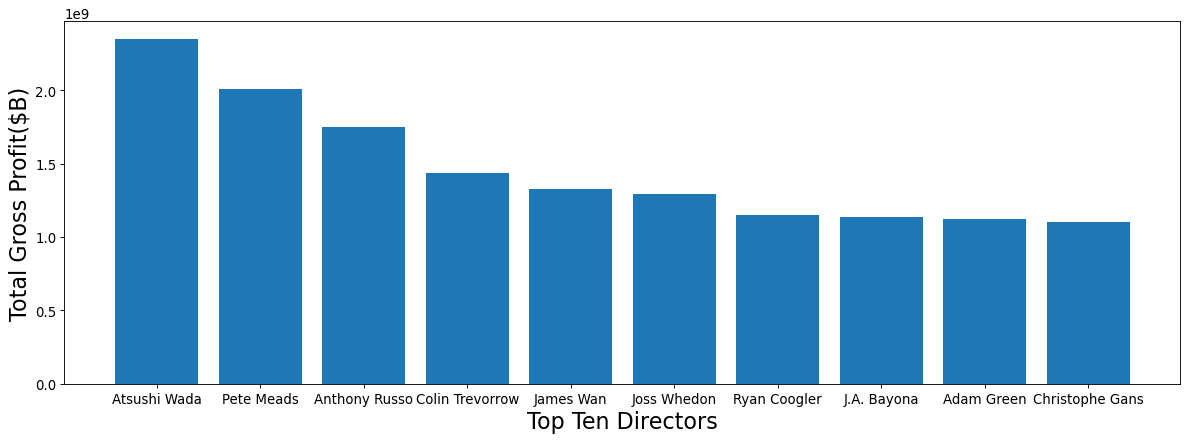

In [74]:
from matplotlib.pyplot import figure
keys = top_profits10.keys()
values = top_profits10.values()
figure(figsize=(18, 6), dpi=80)
plt.rcParams.update({'font.size': 12})
plt.bar(keys, values)
plt.xlabel('Top Ten Directors', fontsize=20)
plt.ylabel('Total Gross Profit($B)', fontsize=20)
plt.show()

## Looking at the number of Blockbuster profitable hits in the top 500 by Director

In [75]:
top_500_appearances = Top_500.director_name.value_counts().head(10).tolist()

In [76]:
Top_500.director_name.value_counts().head(10)

Steven Spielberg      6
Jon M. Chu            5
Ridley Scott          5
James Wan             4
Christopher Nolan     4
Mike Mitchell         4
Anthony Russo         3
Matthew Vaughn        3
Brad Peyton           3
Jaume Collet-Serra    3
Name: director_name, dtype: int64

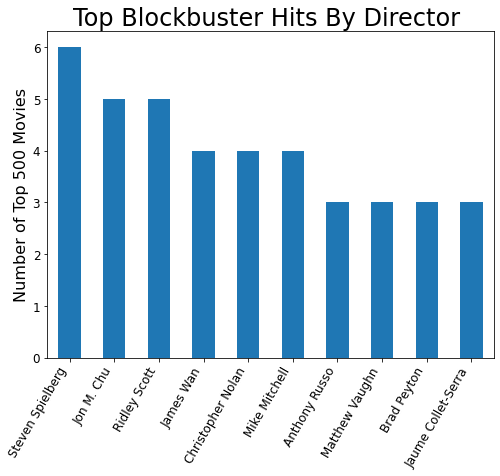

In [77]:
numb_movies = figure(figsize=(8, 6))
Top_500['director_name'].value_counts().head(10).plot(kind='bar');
plt.ylabel('Number of Top 500 Movies', fontsize=16) 
plt.title("Top Blockbuster Hits By Director ", fontsize=24)
plt.xticks(rotation = 60)
plt.xticks(ha='right')
plt.show()
numb_movies.savefig('Top500perdirector', bbox_inches='tight')

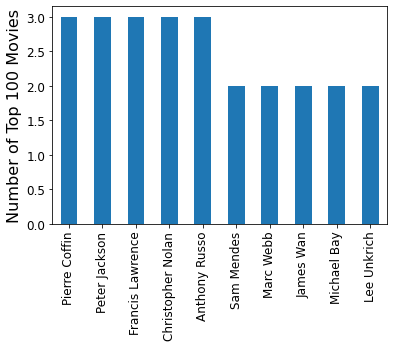

In [78]:
Top_100['director_name'].value_counts().head(10).plot(kind='bar');
plt.ylabel('Number of Top 100 Movies', fontsize=16)
plt.show()

In [79]:
top_directors_list = {'Steven Spielberg', 'Jon M. Chu', 'Ridley Scott', 'James Wan', 'Mike Mitchell', 'Christopher Nolan', 'James DeMonaco', 'Tom McGrath', 'Shawn Levy', 'Tim Burton'} 


## Looking at the Consistently Top Directors and Graphing Scatter Plots of their Relative Success

In [80]:
top_directors_500_df = (Top_500[Top_500.director_name.isin(top_directors_list)])
top_directors_500_df.rename(columns = {'budgets(USD)':'budgets_USD', 'world_gross(USD)':'world_gross_USD'}, inplace = True)
top_directors_500_df.head()


C:\Users\YueYu\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,id,release_date,movie,budgets_USD,dom_gross(USD),world_gross_USD,movie_id,genres,runtime_minutes,Estimated Profit,director_name,estimated_profit
5557,48,"Feb 11, 2011",Justin Bieber: Never Say Never,13000000,73013910,99034125,tt1702443,"Documentary,Music",105.0,86034125,Jon M. Chu,86034125
1939,12,"Dec 25, 2011",War Horse,70000000,79883359,156815529,tt1568911,"Drama,History,War",146.0,86815529,Steven Spielberg,86815529
773,89,"May 11, 2012",Dark Shadows,150000000,79727149,238202668,tt1077368,"Comedy,Fantasy,Horror",113.0,88202668,Tim Burton,88202668
7541,67,"Jun 7, 2013",The Purge,3000000,64473115,91266581,tt2184339,"Horror,Thriller",85.0,88266581,James DeMonaco,88266581
2391,99,"Apr 9, 2010",Date Night,55000000,98711404,152269033,tt1279935,"Comedy,Crime,Romance",88.0,97269033,Shawn Levy,97269033


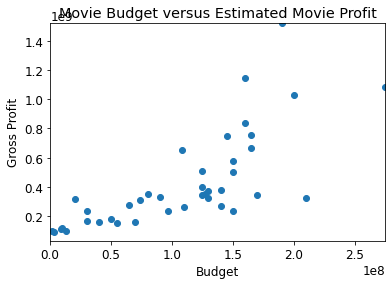

In [44]:
fig, ax = plt.subplots()
ax.scatter(x=top_directors_500_df['budgets_USD'], y=top_directors_500_df['world_gross_USD'])
ax.set(xlim = (0, 2.750000e+08), ylim = (3.126658e+07, 1.518723e+09), 
            title = "Movie Budget versus Estimated Movie Profit",
            xlabel = "Budget",
            ylabel = 'Gross Profit');

ax.set_xlim = (1.500000e+06, 2.750000e+08)
ax.set_ylim =(9.126658e+07, 1.518723e+09)
plt.show()

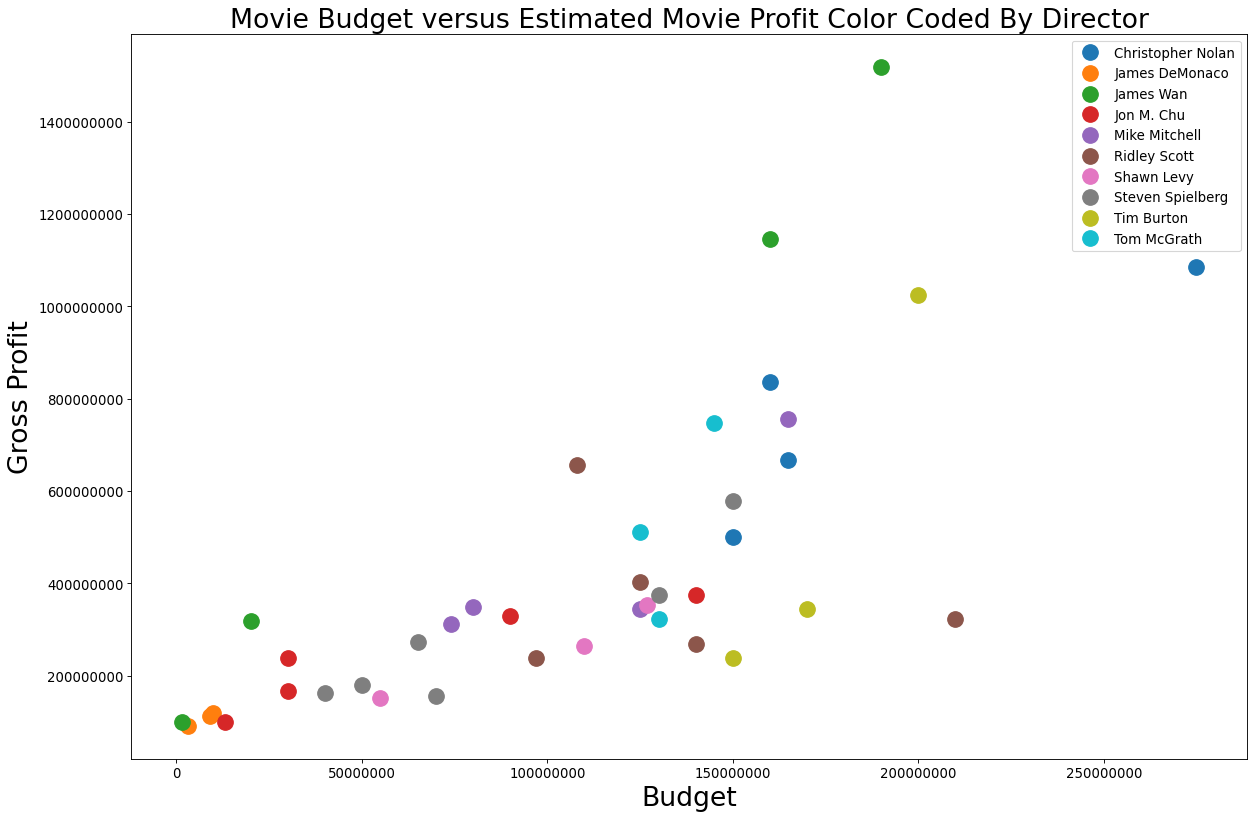

In [45]:
groups = top_directors_500_df.groupby('director_name')

from matplotlib.pyplot import figure

directorcolorcode = figure(figsize=(18, 12), dpi=80)

for name, group in groups:
    
 
    plt.plot(group.budgets_USD, group.world_gross_USD, marker='o', linestyle='', markersize=14, label=name)
    plt.ticklabel_format(style='plain', useOffset=False)
    plt.xlabel('Budget', fontsize=24)
    plt.ylabel('Gross Profit', fontsize=24)
    
  
    plt.title("Movie Budget versus Estimated Movie Profit Color Coded By Director", fontsize=24)

    
   
plt.legend()
directorcolorcode.savefig('Movie_Budget_Director.png')